# Question Selection Analysis based on Estimated Discrmination and Difficulty

In [773]:
student_data = read.csv("astudentData.csv")

#### Discrimination and Difficulty coefficients generated by EM Algorithm using Item Response Theory

In [774]:
coeff_freq = read.csv("coeff.csv")

#### Estimating no of Question Responses for each Question

In [775]:
question_freq = table(student_data$question_id)
question_freq = as.data.frame(question_freq)
colnames(question_freq) =c("question_id","freq")
colnames(question_freq)[1] = "question_id"
coeff_freq=merge(coeff_freq,question_freq,by="question_id")
head(coeff_freq)

,question_id,Diff,Discrm,freq
1,13.000,-0.649,1.526,1061.000
2,21.000,-0.646,1.993,379.000
3,26.000,-0.750,1.355,747.000
4,27.000,-0.337,1.247,1501.000
5,28.000,-1.089,1.215,999.000
6,37.000,-0.702,1.534,855.000


## Outlier Analysis
#### Examining whether Questions with low freq give Anomoulos estimates:
#### Premise: EM will not be able to calculate reasonable estimates for Questions for which there is not enough data, so in the below Analysis I will filter Questions with low frequencies


### Checking for Anomaly in Difficulty and Discrimination

[1]  -3.125   8.741   3.127   4.920 -34.801  -0.555  34.812   4.788

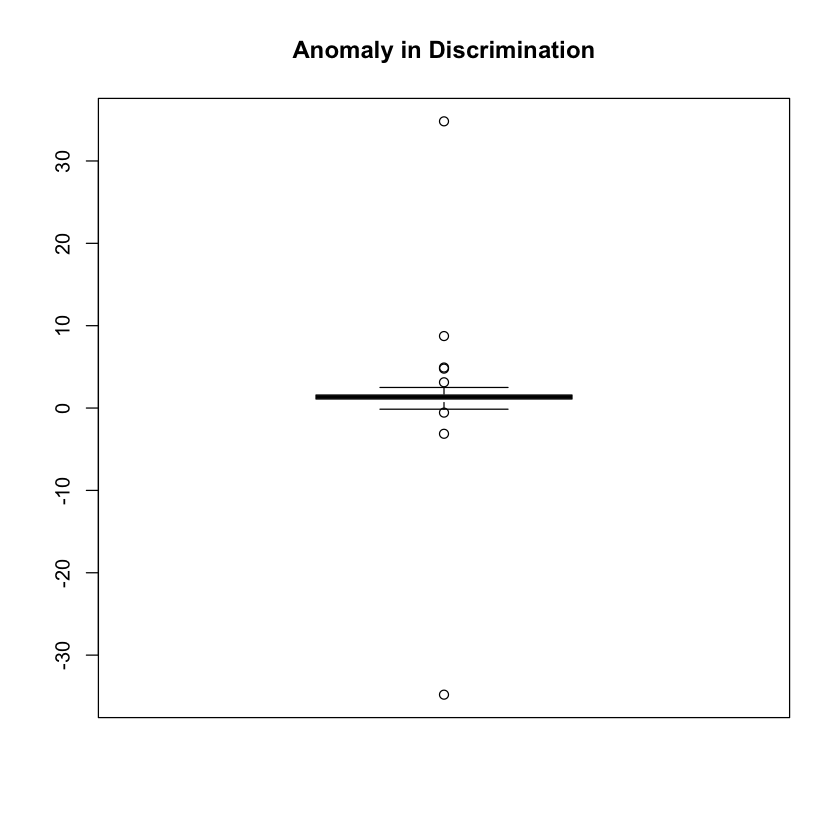

In [776]:
boxplot(coeff_freq$Discrm,main="Anomaly in Discrimination",range = 3)$out

[1]    8.787    3.516 9184.480    5.677    3.113    4.113    3.070    3.394

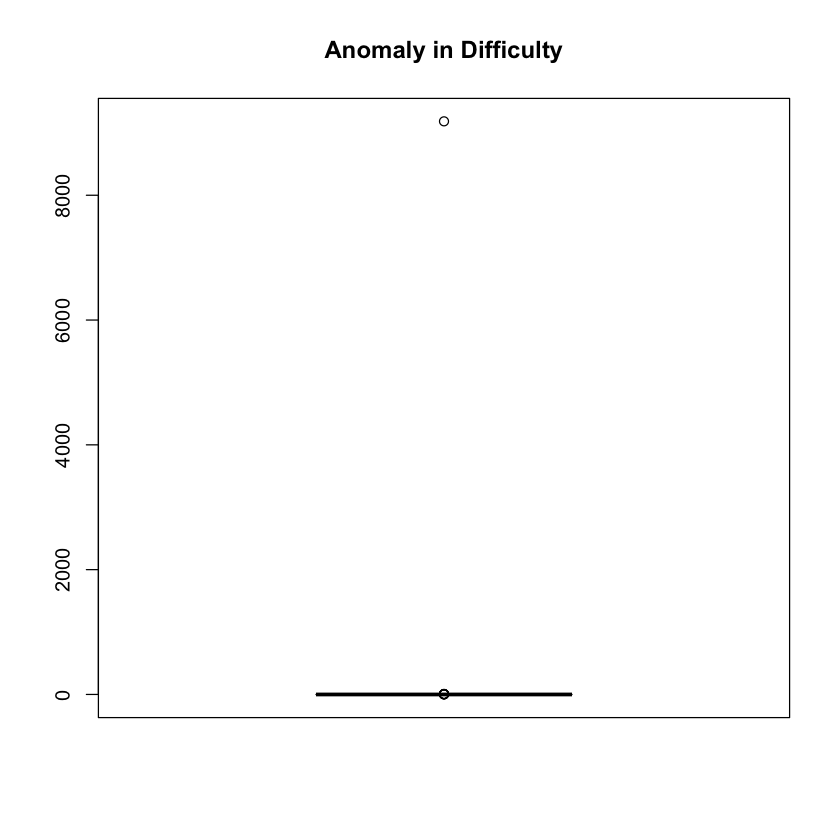

In [777]:
boxplot(coeff_freq$Diff,main="Anomaly in Difficulty",range=3)$out

#### Note: I could have done a standard Hypothesis test  but the below estimates are reasonable estimates

### Finding percentage of outliers in Difficulty and Discrimination in low freq Question Responses

In [778]:
nlow_freq = nrow(coeff_freq[coeff_freq$freq < 40,])
out_freq_Discrm = coeff_freq[coeff_freq$freq < 40,]$Discrm
out_freq_Diff = coeff_freq[coeff_freq$freq < 40,]$Diff
out_Discrm = boxplot(coeff_freq$Discrm,main="Anomaly in Discrimination",plot=F,range=3)$out
out_Diff = boxplot(coeff_freq$Diff,main="Anomaly in Difficulty",range=3,plot=F)$out
out_Diff = as.vector(out_Diff)
out_Discrm = as.vector(out_Discrm)
out_intersect_Discrm = intersect(out_freq_Discrm,out_Discrm)
out_intersect_Diff = intersect(out_freq_Diff,out_Diff)
per = (length(out_intersect_Diff) + length(out_intersect_Discrm))/nlow_freq
print(c("% outliers in low frequent questions",per))

[1] "% outliers in low frequent questions"
[2] "0.666666666666667"                   


### Determining threshold of what Question frequencies not to consider

[1] "freq(mean -1.5*sd): " "102.238916918546"    
             3%      5%     10%     25%     75%    100% 
"Quant"  "39.8" "105.5"   "272"   "519"  "1432"  "3149" 


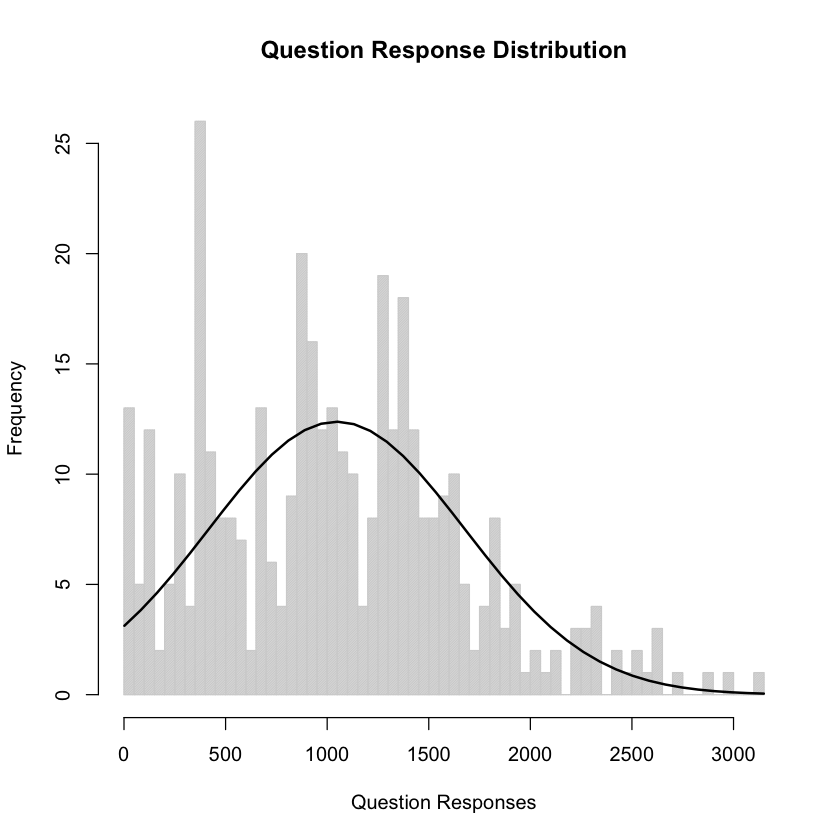

In [779]:
g = coeff_freq$freq
h = hist(g, breaks=100, density=100, col="lightgray", xlab="Question Responses", main="Question Response Distribution") 
    xfit = seq(min(g),max(g),length=40) 
    yfit = dnorm(xfit,mean=mean(g),sd=sd(g)) 
    yfit = yfit*diff(h$mids[1:2])*length(g) 
    lines(xfit, yfit, col="black", lwd=2)
print(c("freq(mean -1.5*sd): ",mean(coeff_freq$freq) - 1.5*sd(coeff_freq$freq)))
print(c("Quant",quantile(coeff_freq$freq,c(0.03,0.05,0.1,0.25,0.75,1))))

In [780]:
coeff_freq_clean = coeff_freq[coeff_freq$freq > 100,]

### Clustering questions into various dfficulty levels

#### Removing outliers for estimating good cluster means for kmeans

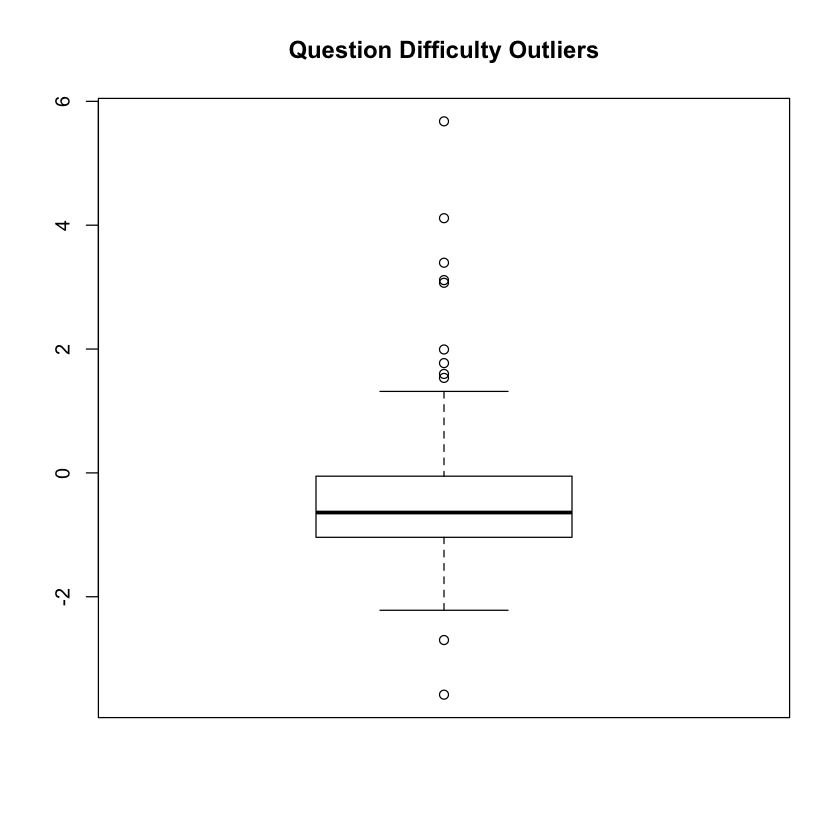

In [781]:
outliers = boxplot(coeff_freq_clean$Diff,main="Question Difficulty Outliers")$stats
upper_whisker = outliers[5]
lower_whisker = outliers[1]
coeff_no_outlier = coeff_freq_clean[(coeff_freq_clean$Diff < upper_whisker ) & (coeff_freq_clean$Diff > lower_whisker),]

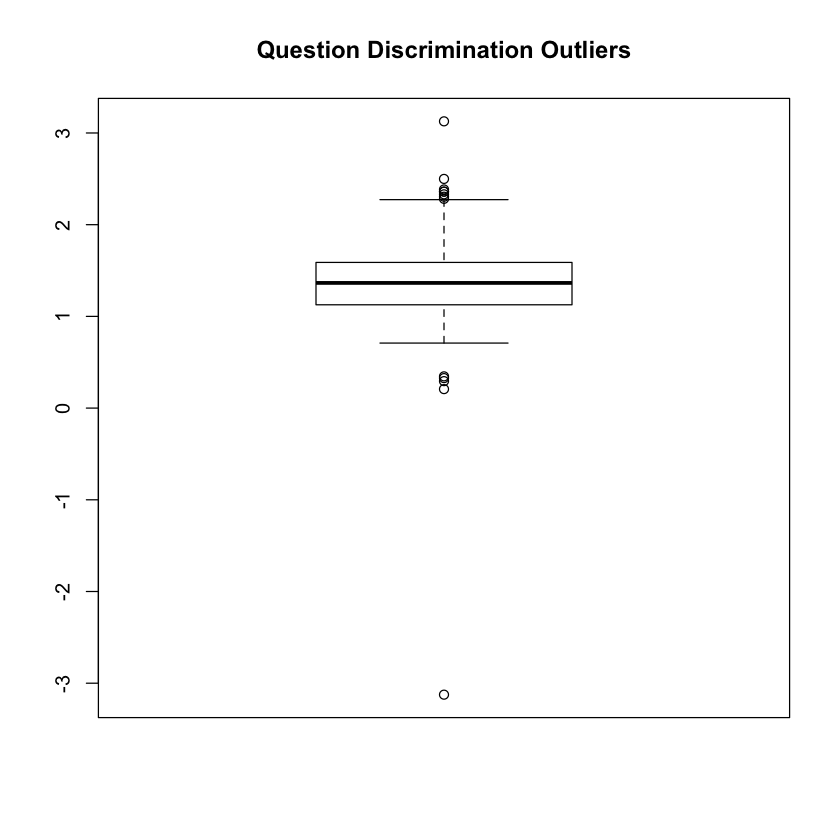

In [782]:
outliers = boxplot(coeff_no_outlier$Discrm, main ="Question Discrimination Outliers")$stats
upper_whisker = outliers[5]
lower_whisker = outliers[1]
coeff_no_outlier = coeff_no_outlier[(coeff_no_outlier$Discrm < upper_whisker ) & (coeff_no_outlier$Discrm > lower_whisker),]

#### Kmeans Clustering with 5 centers 
#### Justification : 5 Questions are Randomly chosen from the bank, so each level should get equal representation, so that a student is tested for all difficulty levels

In [783]:
set.seed(123)
clust = kmeans(coeff_no_outlier$Diff, 5, nstart = 1000)
centers_no_outlier = as.vector(sort(clust$centers))
coeff_freq_clean$Diff_level = sapply(coeff_freq_clean$Diff,function(y) which.min(abs(centers_no_outlier - y)))
head(coeff_freq_clean)
print("Difficulty level (1-5) : 1:Easy, 5:Hard")

,question_id,Diff,Discrm,freq,Diff_level
1,13.000,-0.649,1.526,1061.000,3.000
2,21.000,-0.646,1.993,379.000,3.000
3,26.000,-0.750,1.355,747.000,2.000
4,27.000,-0.337,1.247,1501.000,3.000
5,28.000,-1.089,1.215,999.000,2.000
6,37.000,-0.702,1.534,855.000,3.000


[1] "Difficulty level (1-5) : 1:Easy, 5:Hard"


## Question Selection

#### Grouping Questions based on Question Discrimination Quality - the below estimated are based on standard Item Discrimination scale proposed by Baker(1985)

In [784]:
coeff_freq_clean$Discrm_Quality=0
coeff_freq_clean[coeff_freq_clean$Discrm < 0,]$Discrm_Quality="5_Suspicious"
coeff_freq_clean[(coeff_freq_clean$Discrm > 0) & (coeff_freq_clean$Discrm < 0.34),]$Discrm_Quality="4_very_low"
coeff_freq_clean[(coeff_freq_clean$Discrm >= 0.34) & (coeff_freq_clean$Discrm < 0.64),]$Discrm_Quality="3_low"
coeff_freq_clean[(coeff_freq_clean$Discrm >= 0.64) & (coeff_freq_clean$Discrm < 1.34),]$Discrm_Quality="2_moderate"
coeff_freq_clean[(coeff_freq_clean$Discrm >= 1.34) & (coeff_freq_clean$Discrm < 1.7),]$Discrm_Quality="1_high"
coeff_freq_clean[coeff_freq_clean$Discrm >= 1.7,]$Discrm_Quality="0_very_high"

#### Table - counts of Discrimination Quality vs Question Difiiculty Level

In [785]:
table(coeff_freq_clean$Discrm_Quality,coeff_freq_clean$Diff_level)

              
                1  2  3  4  5
  0_very_high  25 23 21  4  0
  1_high       24 41 30 19  6
  2_moderate   11 38 39 44 35
  3_low         2  0  0  0  4
  4_very_low    0  1  1  0  4
  5_Suspicious  0  0  1  0  0

### Method 1: Keeping Only Top Discriminative Questions

In [786]:
fetch_top_questions = function(level,discrm_grp){
    sel_level = coeff_freq_clean[coeff_freq_clean$Diff_level==level, ]
    sel_level = sel_level[sel_level$Discrm_Quality %in% discrm_grp,]
    sel_level = sel_level[order(sel_level$Discrm,decreasing=TRUE),]
    sel_level$question_id
}
sel_quest_level_1 = fetch_top_questions(1,c("0_very_high","1_high"))
sel_quest_level_2 = fetch_top_questions(2,c("0_very_high","1_high"))
sel_quest_level_3 = fetch_top_questions(3,c("0_very_high","1_high"))
sel_quest_level_4 = fetch_top_questions(4,c("0_very_high","1_high"))
#---Note: Level 5 dosen't have High Discriminative Questions so Moderate grp is also considered"
sel_quest_level_5 = fetch_top_questions(5,c("0_very_high","1_high","2_moderate"))

question_kept = c(sel_quest_level_1,sel_quest_level_2,sel_quest_level_3,sel_quest_level_4 ,sel_quest_level_5)
print(c("Questions Kept:",length(question_kept)))
question_eliminated = all_questions[!(all_questions %in% question_kept)]
print(c("Questions Eliminated:",length(question_eliminated)))

write.csv(question_eliminated,"question_eliminated_1.csv",row.names=F)
write.csv(question_kept,"question_kept_1.csv",row.names=F)
intersect(question_eliminated,question_kept)

[1] "Questions Kept:" "228"            
[1] "Questions Eliminated:" "145"                  


integer(0)

#### Standard Deviation estimates

In [787]:
data = coeff_freq_clean
agg_sd_grp = aggregate(data$Diff, by=list(data$Discrm_Quality,data$Diff_level), FUN=sd)
colnames(agg_sd_grp) = c("Discrm_quality","Level","sd")
agg_sd_grp

,Discrm_quality,Level,sd
1,0_very_high,1,0.198924332347755
2,1_high,1,0.220352776280429
3,2_moderate,1,0.419408739667035
4,3_low,1,1.28339880785358
5,0_very_high,2,0.13839657744403
6,1_high,2,0.143868647748139
7,2_moderate,2,0.101391586987316
8,4_very_low,2,NA
9,0_very_high,3,0.164593886943129
10,1_high,3,0.148838201900008


### Method 2: Selecting Questions to Maximize Ability coverage with reasonable Discriminative Estimates 

In [788]:
fetch_scattered_questions = function(level,k,discrm_grp){ 
    sel_level = coeff_freq_clean[coeff_freq_clean$Diff_level==level, ]
    sel_level = sel_level[sel_level$Discrm_Quality %in% discrm_grp,]
    nrow(sel_level)
    point = sel_level$Diff[1]
    cnt = 0
    questions = c()
    while(cnt < k){
        point_index = which.max(abs(sel_level$Diff - point))
        point = sel_level$Diff[point_index]
        questions = append(questions,sel_level[point_index,]$question_id)
        sel_level = sel_level[-point_index,]
        cnt = cnt + 1
    }
    questions
}

#Note: Standard Deviation table used to select group for each category if the standard deviation of top Discrminative
#     Group, then next Discriminative group is also considered
sel_quest_level_1 = fetch_scattered_questions(1,41,c("0_very_high","1_high","2_moderate"))
sel_quest_level_2 = fetch_scattered_questions(2,41,c("0_very_high","1_high"))
sel_quest_level_3 = fetch_scattered_questions(3,41,c("0_very_high","1_high"))
sel_quest_level_4 = fetch_scattered_questions(4,41,c("0_very_high","1_high","2_moderate"))
sel_quest_level_5 = fetch_scattered_questions(5,41,c("0_very_high","1_high","2_moderate"))

question_kept = c(sel_quest_level_1,sel_quest_level_2,sel_quest_level_3,sel_quest_level_4 ,sel_quest_level_5)
print(c("Questions Kept:",length(question_kept)))
question_eliminated = all_questions[!(all_questions %in% question_kept)]
print(c("Questions Eliminated:",length(question_eliminated)))

question_eliminated = all_questions[!(all_questions %in% question_kept)]
write.csv(question_eliminated,"question_eliminated_2.csv",row.names=F)
write.csv(question_kept,"question_kept_2.csv",row.names=F)
intersect(question_eliminated,question_kept)

[1] "Questions Kept:" "205"            
[1] "Questions Eliminated:" "168"                  


integer(0)

## IRT Model based Discrimination vs Relative Ability Discrimination

### Overlap of low discriminative Power group between the two models

In [789]:
rel_abilitiy_est = read.csv("Discrm_Coll_RelAbility.csv",header = F)
colnames(rel_abilitiy_est) = c("question_id","Discrm")
rel_ability_est = merge(rel_abilitiy_est,question_freq,by="question_id")
rel_ability_est = rel_ability_est[rel_ability_est$freq > 100,]
Rel_Ab_discrm = rel_abilitiy_est[order(rel_abilitiy_est$Discrm),]$question_id[1:200]
EM_discrm = coeff_freq_clean[order(coeff_freq_clean$Discrm),]$question_id[1:200]
low_percentage_overlap =(length(intersect(LTM_discrm,Rel_Ab_discrm))/length(LTM_discrm))
low_percentage_overlap

[1] 0.51

### Correlation between Discriminative estimate in Highly Confidence Question Responses (High Freq)

In [790]:
coeff_freq_clean_2 = coeff_freq_clean[coeff_freq_clean$freq > 500,]
rel_ability_est_2 = rel_ability_est[rel_ability_est$freq > 500,]
IRT_discrm = coeff_freq_clean_2[order(coeff_freq_clean_2$question_id),]$Discrm
rel_ability_discrm = rel_ability_est_2[order(rel_ability_est_2$question_id),]$Discrm
cor.test(IRT_discrm,rel_ability_discrm)


	Pearson's product-moment correlation

data:  IRT_discrm and rel_ability_discrm
t = 6.3716, df = 293, p-value = 7.234e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2443890 0.4453086
sample estimates:
      cor 
0.3488509 


### Suspicious Question Identification Comparison

In [791]:
print("Suspicious Question Index:")
print(c("IRT_discrm:", which(IRT_discrm<0)))
print(c("Rel_ability Discrm:",which(CM_discrm<0)))

[1] "Suspicious Question Index:"
[1] "IRT_discrm:" "141"        
[1] "Rel_ability Discrm:" "141"                
